1. Cкачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('C:/Ангелина/Data Sience/5 четверть/ML in business/4/data.csv', sep=',')

In [3]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [4]:
!pip install scikit-uplift catboost

In [5]:
import numpy as np 

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
from sklift.models import ClassTransformation
from sklift.models import TwoModels

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

2. Поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [6]:
df.rename(columns={'offer':'treatment', 'conversion':'target'}, inplace=True)
df.loc[df['treatment'] != 'No Offer', 'treatment'] = 1
df.loc[df['treatment'] == 'No Offer', 'treatment'] = 0
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [7]:
cat_features = ['zip_code', 'channel']

3. Cделать разбиение набора данных не тренировочную и тестовую выборки

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'),
                                                   df['target'],
                                                   test_size=0.2,
                                                   random_state=42,
                                                   stratify=df['target'])

treat_train = X_train['treatment']
X_train.drop(columns=['treatment'], inplace=True)
treat_val = X_test['treatment']
X_test.drop(columns=['treatment'], inplace=True)

4. Провести uplift-моделирование 3 способами:
   1.одна модель с признаком коммуникации (S-learner)
   2.модель с трансформацией таргета
   3.вариант с двумя независимыми моделями

### 4.1 Одна модель с признаком коммуникации

In [9]:
metrics_df = pd.DataFrame(columns=['model', 'uplift@10%', 'uplift@20%'])
metrics_df

,model,uplift@10%,uplift@20%


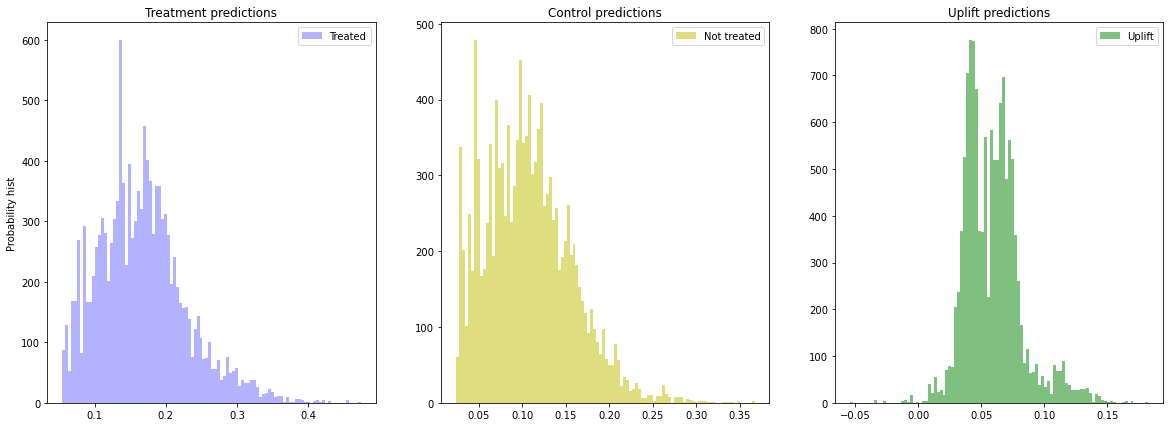

In [10]:
sm = SoloModel(CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)

metrics_df = metrics_df.append({
    'model': type(sm).__name__,
    'uplift@10%': sm_score_10,
    'uplift@20%': sm_score_20
}, ignore_index=True)

# условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

### 4.2 Трансформация таргета

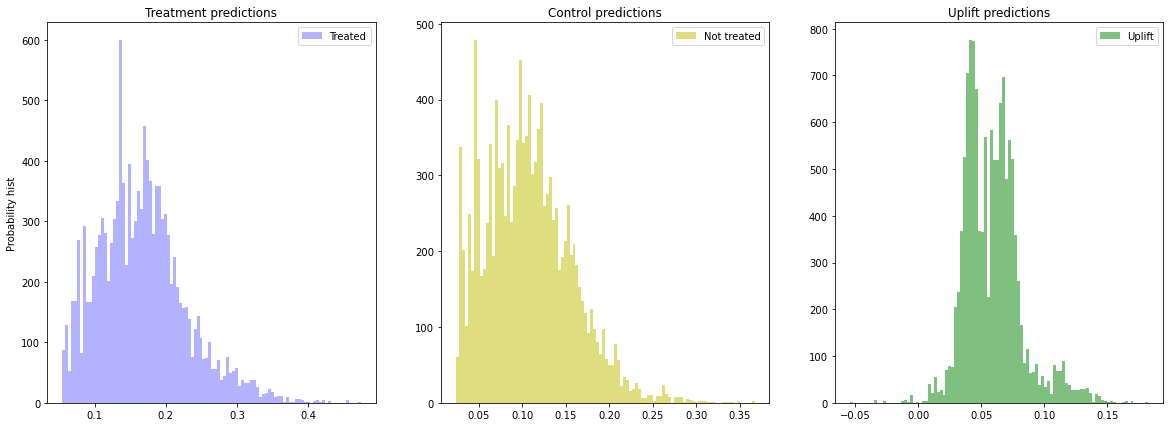

In [11]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)

metrics_df = metrics_df.append({
    'model': type(ct).__name__,
    'uplift@10%': ct_score_10,
    'uplift@20%': ct_score_20
}, ignore_index=True)


#plot_uplift_preds(trmnt_preds=sm.trmnt_preds_, ctrl_preds=sm.ctrl_preds_); # ? sm.

### 4.3 Две независимые модели

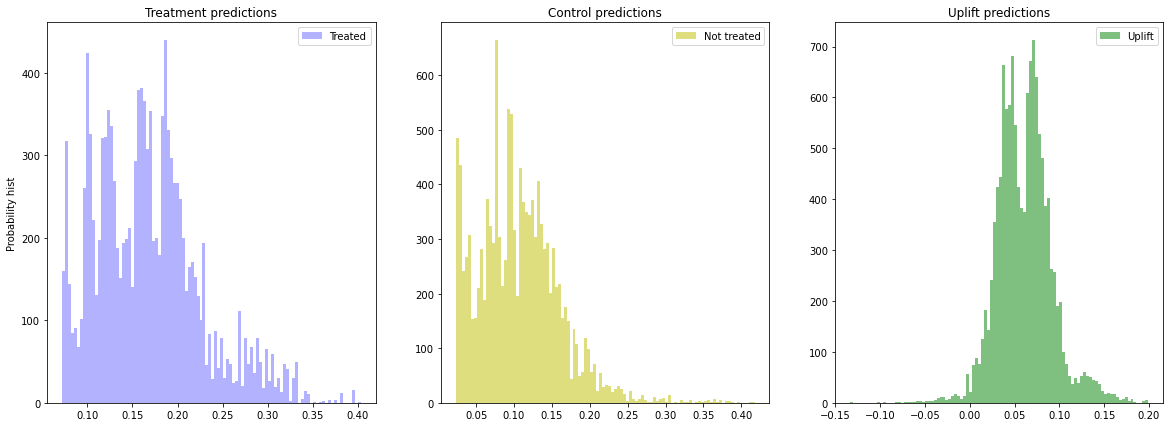

In [12]:
tm = TwoModels(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features),
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features),
    method='vanilla'  
)
tm = tm.fit(
    X_train, y_train, treat_train
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

metrics_df = metrics_df.append({
    'model': type(tm).__name__,
    'uplift@10%': tm_score_10,
    'uplift@20%': tm_score_20
}, ignore_index=True)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

5. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% 3 моделей

In [13]:
metrics_df

,model,uplift@10%,uplift@20%
0,SoloModel,0.074032,0.079493
1,ClassTransformation,0.097725,0.081189
2,TwoModels,0.059486,0.073787


6. *для модели S-learner построить зависимость таргета (конверсии - поле conversion) от значения uplift:
    1. сделать прогноз и получить uplift для тестовой выборки
    2. отсортировать тестовую выборку по uplift по убыванию
    3. разбить на децили (pandas qcut вам в помощь)
    4. для каждого дециля посчитать среднюю conversion

In [14]:
sm = SoloModel(
CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=cat_features))
sm = sm.fit(X_train, y_train, treat_train)
uplift_sm = sm.predict(X_test)

In [15]:
df_test = X_test.copy()
df_test['pred_uplift']=uplift_sm
df_test['conversion'] = y_test
df_test.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,pred_uplift,conversion
28280,1,626.41,1,0,Urban,1,Web,0.047881,0
48420,9,29.99,1,0,Urban,0,Web,0.044250,0
14912,2,130.01,0,1,Surburban,1,Web,0.087838,0
46041,1,883.04,1,1,Surburban,1,Multichannel,0.108701,1
12134,9,48.12,0,1,Rural,0,Web,0.083135,0


In [16]:
df_test = df_test.sort_values(by='pred_uplift', ascending=False)
df_test.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,pred_uplift,conversion
51530,11,371.92,1,1,Rural,1,Web,0.182557,0
44835,1,328.09,1,1,Rural,0,Web,0.169150,1
20183,1,322.77,1,1,Rural,0,Web,0.169150,1
3526,1,354.73,1,1,Rural,0,Web,0.169150,1
51106,1,350.40,1,1,Rural,0,Web,0.169150,0


In [17]:
df_test['deciles'] = pd.qcut(df_test['pred_uplift'], q=10, labels=False)
df_test.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,pred_uplift,conversion,deciles
51530,11,371.92,1,1,Rural,1,Web,0.182557,0,9
44835,1,328.09,1,1,Rural,0,Web,0.169150,1,9
20183,1,322.77,1,1,Rural,0,Web,0.169150,1,9
3526,1,354.73,1,1,Rural,0,Web,0.169150,1,9
51106,1,350.40,1,1,Rural,0,Web,0.169150,0,9


In [18]:
for i in range(0, 10):
    tmp = df_test[df_test['deciles'] == i]
    print(f'Для дециля № {i} средняя конверсия равна {tmp["conversion"].mean():.3f}')

Для дециля № 0 средняя конверсия равна 0.095
Для дециля № 1 средняя конверсия равна 0.109
Для дециля № 2 средняя конверсия равна 0.121
Для дециля № 3 средняя конверсия равна 0.132
Для дециля № 4 средняя конверсия равна 0.111
Для дециля № 5 средняя конверсия равна 0.150
Для дециля № 6 средняя конверсия равна 0.158
Для дециля № 7 средняя конверсия равна 0.158
Для дециля № 8 средняя конверсия равна 0.187
Для дециля № 9 средняя конверсия равна 0.246
